In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 20000

debug = 0

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(strip_unit=8*4, verbose=1):
  tree = load_pgun()
  
  outs = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      assert(hit.emtf_phi < 5120)
      
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    #print "ievt {0} nhits {1}".format(ievt, len(evt.hits))
    #print "..", sector_cnt_array
    #print "..", sector_cnt_array[best_sector]
    #print "..", sector_phi_array[best_sector]
    
    # Find the best phi bin
    phis = sector_phi_array[best_sector]
    phis = np.asarray(phis)
    
    # Overlapping bins
    bins1 = np.arange(0, 5120, strip_unit)
    bins2 = np.arange(-strip_unit/2, 5120+strip_unit/2, strip_unit)
    if len(bins2):
      binned_phis1 = np.digitize(phis, bins=bins1[1:])  # skip lowest edge
      binned_phis2 = np.digitize(phis, bins=bins2[1:])  # skip lowest edge
      binned_phis_with_counts1 = np.unique(binned_phis1, return_counts=True)
      binned_phis_with_counts2 = np.unique(binned_phis2, return_counts=True)
      if np.max(binned_phis_with_counts1[1]) >= np.max(binned_phis_with_counts2[1]):
        bins = bins1
        binned_phis = binned_phis1
        binned_phis_with_counts = binned_phis_with_counts1
      else:
        bins = bins2
        binned_phis = binned_phis2
        binned_phis_with_counts = binned_phis_with_counts2
    else:
      bins = bins1
      binned_phis = np.digitize(phis, bins=bins[1:])  # skip lowest edge
      binned_phis_with_counts = np.unique(binned_phis, return_counts=True)
    
    best_bin_tmp = np.argmax(binned_phis_with_counts[1])
    best_bin = binned_phis_with_counts[0][best_bin_tmp]
    best_bin_cnt = binned_phis_with_counts[1][best_bin_tmp]
    #frac = float(best_bin_cnt)/len(phis)
    
    best_bin_phis = phis[binned_phis == best_bin]
    if len(best_bin_phis):
      delta = np.max(best_bin_phis) - np.min(best_bin_phis)
    else:
      delta = 0
    
    # Debug
    if verbose and debug:
      print part.pt, best_bin, len(phis), best_bin_cnt, delta, phis, binned_phis_with_counts1, binned_phis_with_counts2
    
    outs.append((part.pt, len(phis), best_bin_cnt, delta))

  return np.asarray(outs)

In [5]:
#eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30.)
edges = np.asarray(eff_pt_bins)

def post_analysis(outs):
  xdata = (edges[1:] + edges[:-1])/2

  denom = np.zeros_like(xdata, dtype=np.float32)
  numer = np.zeros_like(xdata, dtype=np.float32)

  for o in outs:
    (pt, cnt, bin_cnt, delta) = o
    x = np.digitize(pt, bins=eff_pt_bins[1:])  # skip lowest edge
    if x == len(xdata):
      x -= 1
    denom[x] += 1
    if float(bin_cnt)/cnt > 7./8:
      numer[x] += 1

  denom[denom == 0] = 1
  ydata = np.true_divide(numer, denom)
  return xdata, ydata

In [6]:
strip_unit = 5120/8
outs = analysis(strip_unit=strip_unit)
xdata, ydata = post_analysis(outs)

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000


In [7]:
print strip_unit
print outs
print xdata, ydata

640
[[2.49785972e+00 1.00000000e+01 1.00000000e+01 4.92000000e+02]
 [2.50455952e+00 7.00000000e+00 7.00000000e+00 2.69000000e+02]
 [1.67715244e+01 9.00000000e+00 9.00000000e+00 6.30000000e+01]
 ...
 [4.11106443e+00 6.00000000e+00 6.00000000e+00 2.14000000e+02]
 [3.20642700e+01 1.10000000e+01 1.10000000e+01 7.80000000e+01]
 [3.42578955e+03 1.50000000e+01 1.50000000e+01 3.84000000e+02]]
[ 0.25  0.75  1.25  1.75  2.5   3.5   4.5   5.5   6.5   7.5   9.   11.
 13.   15.   17.   19.   21.   23.   25.5  28.5 ] [0.         0.         0.         0.         0.6389573  0.89962184
 0.9772469  0.9918567  0.9952494  0.9969834  0.9988938  1.
 0.99313504 1.         0.9961977  0.99561405 1.         1.
 1.         0.99539524]


In [8]:
if False:
  plt.style.use('tdrstyle.mplstyle')
  plt.figure()

  strip_units = [8*4, 8*8, 8*16, 8*32, 5120/16, 5120/8, 5120/4, 5120/2]

  for strip_unit in strip_units:
    print('Using strip_unit {0}'.format(strip_unit))
    outs = analysis(strip_unit=strip_unit, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(strip_units, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()

In [9]:
if False:
  # Mock minbias pT spectrum
  #xx = np.linspace(0.1, 49.1, num=50)
  xx = np.linspace(2.1, 52.1, num=101)
  #reweight = lambda x: 5.5 * np.power(x,-3)
  #reweight = lambda x: 11 * np.power(x,-4)
  reweight = lambda x: 7.778 * np.power(x,-3.5)
  xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)
  xw_cumsum = np.cumsum(xw)
  xw_cumsum /= xw.sum()
  print zip(xx, xw_cumsum)

In [23]:
#maxEvents = 20000
maxEvents = 200000  #FIXME

debug = 0

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

nchannels = 4  # (ring1/ring2) x (F/R)

layer_names = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4', 
               'RE1', 'RE2', 'RE3', 'RE4', 
               'GE1/1', 'GE2/1', 'ME0']
ordered_layer_names = ['ME0', 'GE1/1', 'ME1/1', 
                       'ME1/2', 'RE1',
                       'GE2/1', 'RE2', 'ME2',
                       'ME3', 'RE3',
                       'ME4', 'RE4']
ordered_layer_mapping = [(nlayers-1) - ordered_layer_names.index(x) for x in layer_names]

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    return self.lut[index]

find_emtf_layer = EMTFLayer()

# Decide EMTF channel number (F/R + ring)
class EMTFChannel(object):
  def __init__(self):
    lut = np.zeros((2,2), dtype=np.int32) - 99
    lut[0,0] = 0  # ring 1 or 4, R
    lut[0,1] = 1  # ring 1 or 4, F
    lut[1,0] = 2  # ring 2 or 3, R
    lut[1,1] = 3  # ring 2 or 3, F
    self.lut = lut

  def __call__(self, hit):
    tmp_ring = 1 if (hit.ring == 2) or (hit.ring == 3) else 0
    tmp_fr = 1 if (hit.fr == 1) else 0
    index = (tmp_ring, tmp_fr)
    return self.lut[index]

find_emtf_channel = EMTFChannel()


#FIXME: add eta partitions
#FIXME: format 1/pT
#FIXME: add other variables
#FIXME: dont reduce strip_unit by 8
def make_images(strip_unit=8*4, verbose=1):
  tree = load_pgun()
  
  images = []
  labels = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      
      sector_cnt_array[endsec] += 1
      sector_hits_array[endsec].append(hit)
    
    best_sector = np.argmax(sector_cnt_array)
    
    # Find the best superstrip, include overlaps
    sector_hits = sector_hits_array[best_sector]
    phis = [hit.emtf_phi for hit in sector_hits]
    bins1 = np.arange(0, 5120, strip_unit)
    bins2 = np.arange(-strip_unit/2, 5120+strip_unit/2, strip_unit)
    if len(bins2):
      binned_phis1 = np.digitize(phis, bins=bins1[1:])  # skip lowest edge
      binned_phis2 = np.digitize(phis, bins=bins2[1:])  # skip lowest edge
      binned_phis_with_counts1 = np.unique(binned_phis1, return_counts=True)
      binned_phis_with_counts2 = np.unique(binned_phis2, return_counts=True)
      if np.max(binned_phis_with_counts1[1]) >= np.max(binned_phis_with_counts2[1]):
        bins = bins1
        binned_phis = binned_phis1
        binned_phis_with_counts = binned_phis_with_counts1
      else:
        bins = bins2
        binned_phis = binned_phis2
        binned_phis_with_counts = binned_phis_with_counts2
    else:
      bins = bins1
      binned_phis = np.digitize(phis, bins=bins[1:])  # skip lowest edge
      binned_phis_with_counts = np.unique(binned_phis, return_counts=True)
    
    best_bin_tmp = np.argmax(binned_phis_with_counts[1])
    best_bin = binned_phis_with_counts[0][best_bin_tmp]
    best_bin_cnt = binned_phis_with_counts[1][best_bin_tmp]
    #frac = float(best_bin_cnt)/len(phis)
    
    best_bin_idx = (binned_phis == best_bin)
    reduce_list_f = lambda x, mask: [x[i] for i in np.where(mask)[0]]
    best_bin_hits = reduce_list_f(sector_hits, best_bin_idx)
    
    #image_shape = (nlayers, strip_unit, nchannels)
    #image_shape = (nlayers, strip_unit)
    image_shape = (nlayers, strip_unit/8)
    image = np.zeros(image_shape, dtype=np.float32)
    
    # Debug
    if verbose and debug and ievt < 10:
      print("ievt {0}".format(ievt))
    
    for ihit, hit in enumerate(best_bin_hits):
      l = find_emtf_layer(hit)
      c = find_emtf_channel(hit)
      phi = hit.emtf_phi
      theta = hit.emtf_theta
      time = hit.bx
      
      phi_sub = phi - bins[best_bin]
      assert(0 <= phi_sub < strip_unit)
      
      # reorder layers
      ll = ordered_layer_mapping[l]
      
      #FIXME: ignore channels for now
      #image[ll, phi_sub, c] = 1
      #image[ll, phi_sub] = 1
      image[ll, phi_sub/8] = 1
      
      # Debug
      if verbose and debug and ievt < 10:
        print "..", (l, c, phi, theta, time), bins[best_bin], phi_sub
    
    images.append(image)
    
    label = (part.pt > 14)
    labels.append(label)
  
  return np.asarray(images), np.asarray(labels)

In [24]:
strip_unit = 5120/8
images, labels = make_images(strip_unit=strip_unit)
print images.shape, labels.shape

outfile = 'histos_tbe.npz'
np.savez_compressed(outfile, images=images, labels=labels)

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processin

In [25]:
# Styling
plt.style.use('tdrstyle.mplstyle')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,2.5)
#mpl.rcParams['axes.labelpad'] = 0
#mpl.rcParams['axes.labelsize'] = 0
#mpl.rcParams['xtick.labelsize'] = 0
#mpl.rcParams['ytick.labelsize'] = 0

(12, 80)


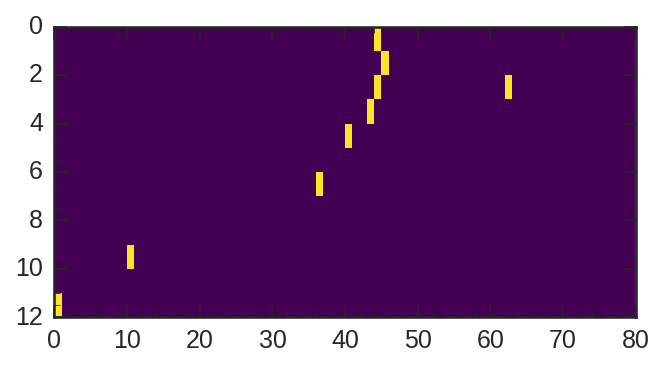

In [26]:
#aspect = float(strip_unit)/nlayers
#aspect = 20
aspect = 'auto'

image = images[0]
print image.shape
#print np.where(image[:,:,0])
#print np.where(image[:,:,1])
#print np.where(image[:,:,2])
#print np.where(image[:,:,3])
#plt.imshow(image[:,:,0], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
#plt.show()
#plt.imshow(image[:,:,1], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
#plt.show()
#plt.imshow(image[:,:,2], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
#plt.show()
#plt.imshow(image[:,:,3], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
#plt.show()
plt.imshow(image, cmap='viridis', interpolation='none', extent=(0,strip_unit/8,nlayers,0), aspect=aspect)
plt.show()

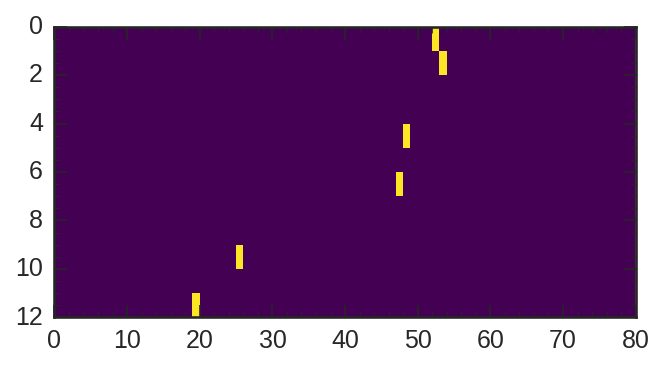

In [27]:
image = images[1]
#print np.where(image[:,:,0])
#plt.imshow(image[:,:,0], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
plt.imshow(image, cmap='viridis', interpolation='none', extent=(0,strip_unit/8,nlayers,0), aspect=aspect)
plt.show()

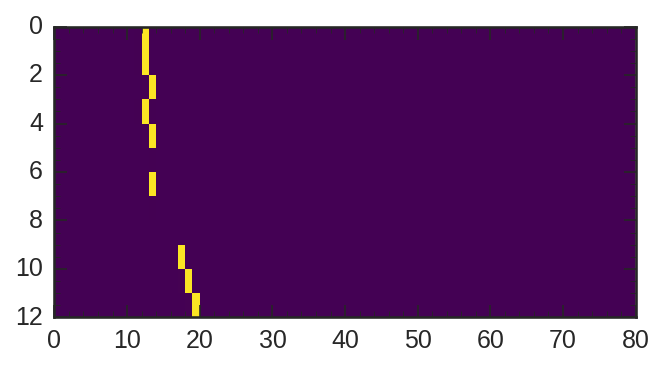

In [28]:
image = images[2]
#print np.where(image[:,:,0])
#plt.imshow(image[:,:,0], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
plt.imshow(image, cmap='viridis', interpolation='none', extent=(0,strip_unit/8,nlayers,0), aspect=aspect)
plt.show()

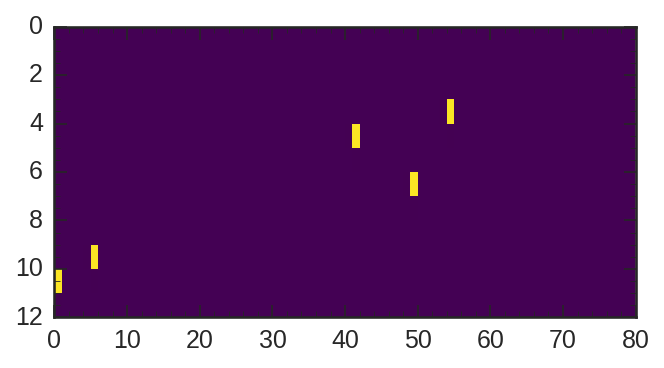

In [29]:
image = images[3]
#print np.where(image[:,:,0])
#plt.imshow(image[:,:,0], cmap='viridis', interpolation='none', extent=(0,strip_unit,nlayers,0), aspect=aspect)
plt.imshow(image, cmap='viridis', interpolation='none', extent=(0,strip_unit/8,nlayers,0), aspect=aspect)
plt.show()